# Prediction of used car prices -  challenge to handle and model real life data

____

## Project objective
The objective of the project is to get the best possible used car price prediction in accordance to a set of available dimensions and metrics with use of ML methods that I have learned from the Data Science extramural Bootcamp. The prediction will be evalueated by R2 and MAE score.

The data for the project is a real world used car ads records originated from Kaggle (https://www.kaggle.com/mirosval/personal-cars-classifieds). The data was scraped by Miroslav Zoricak from several websites in Czech Republic and Germany over a period of more than a year within late 2015 and early 2017.

The original dataframe includes the following columns:
- <b>maker</b>- normalized all lowercase
- <b>model</b> - normalized all lowercase
- <b>mileage</b> - in KM
- <b>manufacture_year</b>
- <b>engine_displacement</b> - in ccm
- <b>engine_power</b> - in kW (converted in data prep to HP)
- <b>body_type</b> - almost never present, but I scraped only personal cars, no motorcycles or utility vehicles
- <b>color_slug</b> - also almost never present
- <b>stk_year</b> - year of the last emission control
- <b>transmission</b> - automatic or manual
- <b>door_count</b>
- <b>seat_count</b>
- <b>uel_type</b> - gasoline, diesel, cng, lpg, electric
- <b>date_created</b> - when the ad was scraped
- <b>datelastseen</b> - when the ad was last seen. Our policy was to remove all ads older than 60 days
- <b>price_eur</b> - list price converted to EUR


The autor of the data claims that data scraped can not provide accurate predictions due to data quality issues, i.e. missing values, variance, and presence of outliers. Having this noted, thorough data cleansing is one of the major project challanges. The possible outcome can bring up significant data reduction but should increase accuracy of predictions.

It is also important to remark that data provided does not contain such important information as condition of a car, how it is equipped, or possible bumbs in a history of a car. They are all crucial to better set up and predict the price for the model.  

Despite this leakage I will attempt to reach best possible evaluation scores in general and check out how the price predictions perform across most popular ML models.

Since the raw data is very extensive in volume (over 3,5 million records) I will limit it by sampling 50 000 of the used car examplesfurther in the project.

*******

## 1. Getting and limiting the raw file

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import datetime as dt

sns.set_style('whitegrid')
%matplotlib inline

random_seed=42

# switch off future warning
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [250]:
df = pd.read_csv('./cars.csv', sep=',', low_memory=False)
df.head(5)

,maker,model,mileage,manufacture_year,engine_displacement,engine_power,body_type,color_slug,stk_year,transmission,door_count,seat_count,fuel_type,date_created,date_last_seen,price_eur
0,ford,galaxy,151000.0,2011.0,2000.0,103.0,NaN,NaN,None,man,5,7,diesel,2015-11-14 18:10:06.838319+00,2016-01-27 20:40:15.46361+00,10584.75
1,skoda,octavia,143476.0,2012.0,2000.0,81.0,NaN,NaN,None,man,5,5,diesel,2015-11-14 18:10:06.853411+00,2016-01-27 20:40:15.46361+00,8882.31
2,bmw,NaN,97676.0,2010.0,1995.0,85.0,NaN,NaN,None,man,5,5,diesel,2015-11-14 18:10:06.861792+00,2016-01-27 20:40:15.46361+00,12065.06
3,skoda,fabia,111970.0,2004.0,1200.0,47.0,NaN,NaN,None,man,5,5,gasoline,2015-11-14 18:10:06.872313+00,2016-01-27 20:40:15.46361+00,2960.77
4,skoda,fabia,128886.0,2004.0,1200.0,47.0,NaN,NaN,None,man,5,5,gasoline,2015-11-14 18:10:06.880335+00,2016-01-27 20:40:15.46361+00,2738.71


The original dataset is quite extensive in volume:

In [251]:
len(df)

3552912

Checking out when cars were scraped:

In [252]:
df['year'] = pd.to_datetime(df['date_created']).dt.year
df['month'] = pd.to_datetime(df['date_created']).dt.month.map("{:02}".format)

df['created_year_month']= df[['year', 'month']].astype(str).agg('_'.join, axis=1)

df.sort_values(by='created_year_month', inplace=True)

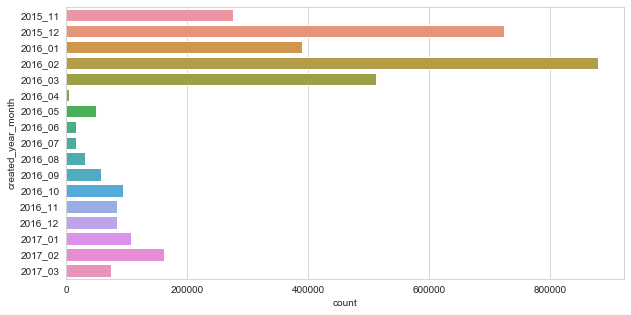

In [253]:
plt.figure(figsize=(10,5))
sns.countplot(y=df['created_year_month'])
plt.show()

As we can see above, the volumes of car ads per month vary, especially across March and Aprill 2016. This is presumably because scrapping method had been tuned up in that time. I decided to shorten the scraping timeframe window, as this should provide more coherent data and improve overall prediction accuracy.

In [254]:
df.groupby(['created_year_month'])['price_eur'].describe()

,count,mean,std,min,25%,50%,75%,max
created_year_month,,,,,,,,
2015_11,274925.0,1.233104e+04,3.697931e+05,0.04,1490.2300,5366.40,13404.00,1.000148e+08
2015_12,724271.0,2.202072e+04,7.204187e+05,0.04,3951.4800,10078.98,18010.66,3.404523e+08
2016_01,389107.0,1.813875e+04,4.169198e+05,370.10,4001.5200,10408.40,18866.69,1.000074e+08
2016_02,879196.0,6.528335e+06,4.071998e+09,370.10,5657.0825,11950.00,19990.00,2.706149e+12
2016_03,511399.0,1.644282e+04,2.899182e+05,370.10,4996.8200,11499.00,19790.00,1.001332e+08
2016_04,4297.0,1.439998e+04,3.580285e+04,370.10,2849.7400,6846.78,14208.29,5.464202e+05
2016_05,48869.0,1.126372e+04,1.914449e+04,370.10,2900.1100,7134.27,14803.81,1.715063e+06
2016_06,15497.0,7.837597e+03,9.455459e+03,370.10,2775.7200,5514.43,9992.56,2.960400e+05
2016_07,15898.0,7.467093e+03,8.804289e+03,370.10,2775.7200,5181.31,9215.40,2.331606e+05


Eventually the scraped period will get limited to January 2016 - March 2016, as further scrapings do not show variance in the predicted variable (price_eur).

In [255]:
df = df[df['created_year_month'].between('2016_01','2016_03')]
df.to_csv('.\Cars_Jan_Mar_2016.csv')

******************************


# 2. Data preparation

In [142]:
df = pd.read_csv('./Cars_Jan_Mar_2016.csv', sep=',', low_memory=False, index_col=[0])

In [143]:
df.head()

,maker,model,mileage,manufacture_year,engine_displacement,engine_power,body_type,color_slug,stk_year,transmission,door_count,seat_count,fuel_type,date_created,date_last_seen,price_eur,year,month,created_year_month
1258599,hyundai,i10,44373.0,2011.0,1086.0,49.0,NaN,NaN,None,man,4,5,gasoline,2016-01-15 23:48:18.351263+00,2016-07-03 18:07:57.593938+00,5900.22,2016,1,2016_01
1258590,fiat,NaN,149000.0,2000.0,1900.0,NaN,NaN,NaN,None,man,4,None,diesel,2016-01-15 23:48:00.139562+00,2016-01-20 09:03:13.640667+00,1999.07,2016,1,2016_01
1258602,audi,a1,79850.0,2011.0,1390.0,90.0,NaN,NaN,None,auto,2,4,gasoline,2016-01-15 23:48:18.44457+00,2016-07-03 18:08:03.813917+00,11990.45,2016,1,2016_01
1258603,hyundai,i10,25.0,2016.0,998.0,49.0,NaN,NaN,None,auto,4,5,gasoline,2016-01-15 23:48:18.473834+00,2016-07-03 18:08:18.223965+00,9235.34,2016,1,2016_01
1258600,hyundai,i20,50785.0,2012.0,1248.0,63.0,NaN,NaN,None,man,4,5,gasoline,2016-01-15 23:48:18.38062+00,2016-07-03 18:08:02.791752+00,8450.30,2016,1,2016_01


In [144]:
raw_len = len(df)
print(raw_len)

1779702


In [145]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1779702 entries, 1258599 to 2437959
Data columns (total 19 columns):
maker                  object
model                  object
mileage                float64
manufacture_year       float64
engine_displacement    float64
engine_power           float64
body_type              object
color_slug             object
stk_year               object
transmission           object
door_count             object
seat_count             object
fuel_type              object
date_created           object
date_last_seen         object
price_eur              float64
year                   int64
month                  int64
created_year_month     object
dtypes: float64(5), int64(2), object(12)
memory usage: 271.6+ MB


In [146]:
df.columns

Index(['maker', 'model', 'mileage', 'manufacture_year', 'engine_displacement',
       'engine_power', 'body_type', 'color_slug', 'stk_year', 'transmission',
       'door_count', 'seat_count', 'fuel_type', 'date_created',
       'date_last_seen', 'price_eur', 'year', 'month', 'created_year_month'],
      dtype='object')

Converting engine_power from kW to HP units, since I am better acquainted with HP metrics.

In [147]:
df['engine_power'] = 1.3410220888*df['engine_power']

Calculating the age of a car in a moment when the ad was scraped, instead of the manufacturing_year.

In [148]:
df['age_years'] = (df['year']-df['manufacture_year'])
df.drop(columns=['manufacture_year', 'year', 'month'], inplace=True)

Checking out the % share of null values across variables

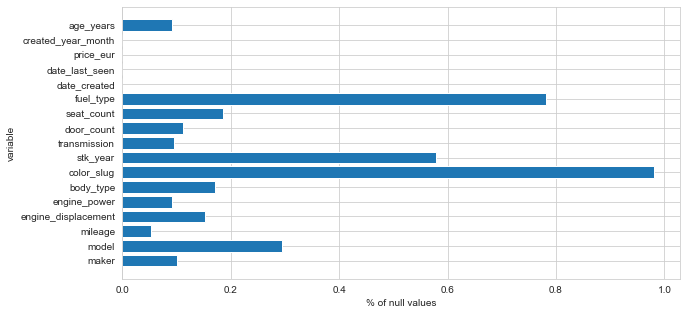

In [149]:
plt.figure(figsize=(10,5))
plt.barh(df.columns, width = df.isnull().sum()/len(df))
plt.xlabel('% of null values')
plt.ylabel('variable')
plt.show()

It seems that a number of variables have lot of missing values:

date_last_seen  - does not bring any useful information (as the policy was to remove all ads that had not been seen more than 60 days before scraping).

stk_year, color_slug  - variables that definitely need to be removed from the dataset because of missing values

In [150]:
df.drop(columns=['stk_year', 'color_slug', 'date_last_seen'], inplace=True)

Checking out fuel type as it is not present in most cases.

In [151]:
df['fuel_type'].value_counts()

gasoline    205837
diesel      183270
Name: fuel_type, dtype: int64

fuel_type should be important to predict the price but stands out in terms of missing values.
However, it can not be easily imputed, since the same engine capacities can ran with different fuel. Therefore I also decided to drop the variable. I will not be helpful in accordance to new car records.

In [152]:
df.drop(columns='fuel_type', inplace=True)

If no maker, model or manufacture_year is present in the dataset, we can not say if the price prediction is correct. These cases will also get dropped.

In [153]:
df.dropna(subset=['maker', 'model', 'age_years'], inplace=True)

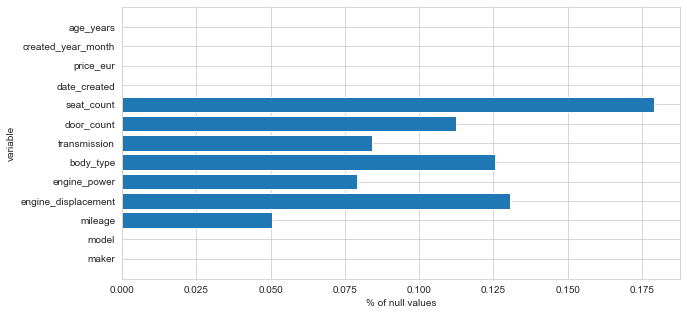

In [154]:
plt.figure(figsize=(10,5))
plt.barh(df.columns, width = df.isnull().sum()/len(df))
plt.xlabel('% of null values')
plt.ylabel('variable')
plt.show()

In [155]:
df.head()

,maker,model,mileage,engine_displacement,engine_power,body_type,transmission,door_count,seat_count,date_created,price_eur,created_year_month,age_years
1258599,hyundai,i10,44373.0,1086.0,65.710082,NaN,man,4,5,2016-01-15 23:48:18.351263+00,5900.22,2016_01,5.0
1258602,audi,a1,79850.0,1390.0,120.691988,NaN,auto,2,4,2016-01-15 23:48:18.44457+00,11990.45,2016_01,5.0
1258603,hyundai,i10,25.0,998.0,65.710082,NaN,auto,4,5,2016-01-15 23:48:18.473834+00,9235.34,2016_01,0.0
1258600,hyundai,i20,50785.0,1248.0,84.484392,NaN,man,4,5,2016-01-15 23:48:18.38062+00,8450.30,2016_01,4.0
1258601,hyundai,santa-fe,14487.0,2199.0,194.448203,NaN,auto,4,5,2016-01-15 23:48:18.410752+00,27901.04,2016_01,4.0


### Filtering out the outlier values

The variables present a lot of variance. Some values are out of the reasonable range. See the table below:

In [156]:
df.describe()

,mileage,engine_displacement,engine_power,price_eur,age_years
count,1.081564e+06,990232.000000,1.048723e+06,1.138866e+06,1.138866e+06
mean,9.902788e+04,1814.424140,1.232749e+02,6.879184e+04,8.826922e+00
std,2.633064e+05,1342.416534,5.987303e+01,2.795810e+07,4.388576e+01
min,0.000000e+00,1.000000,2.682044e+00,3.701000e+02,0.000000e+00
25%,2.150000e+04,1389.000000,8.850746e+01,4.600000e+03,2.000000e+00
50%,7.679950e+04,1598.000000,1.086228e+02,9.980000e+03,5.000000e+00
75%,1.385000e+05,1968.000000,1.408073e+02,1.697000e+04,1.000000e+01
max,9.999999e+06,32000.000000,2.016897e+03,1.492235e+10,2.016000e+03


The dataset obiously shows outliers. I decided to trim 0.5 percentile values on each edge of a variable.
The outliers will be replaced with np.nan values and imputed in further steps.

In [157]:
for i in df.describe().columns:
    df[i] = np.where(df[i].between(df[i].quantile(q=0.005), df[i].quantile(q=0.995)), df[i], np.nan)

In [158]:
df.describe()

,mileage,engine_displacement,engine_power,price_eur,age_years
count,1.076156e+06,980509.000000,1.039204e+06,1.127484e+06,1.133362e+06
mean,8.757411e+04,1746.097122,1.216716e+02,1.239726e+04,6.744254e+00
std,7.429605e+04,607.581520,5.250845e+01,1.070496e+04,5.721709e+00
min,0.000000e+00,800.000000,4.961782e+01,5.181300e+02,0.000000e+00
25%,2.128600e+04,1390.000000,8.850746e+01,4.663210e+03,2.000000e+00
50%,7.600000e+04,1598.000000,1.086228e+02,9.980000e+03,5.000000e+00
75%,1.372500e+05,1968.000000,1.408073e+02,1.690000e+04,1.000000e+01
max,3.723460e+05,6800.000000,4.237630e+02,8.032500e+04,4.500000e+01


We will next attempt to drop outliers for door_count and seat_count, as both variables are strings.

In [159]:
df[['door_count', 'seat_count']] = df[['door_count', 'seat_count']].replace('None', np.nan).apply(pd.to_numeric)

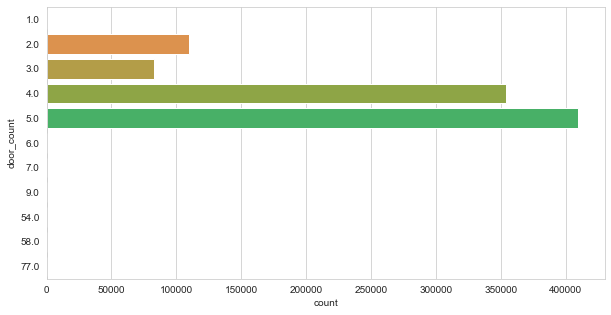

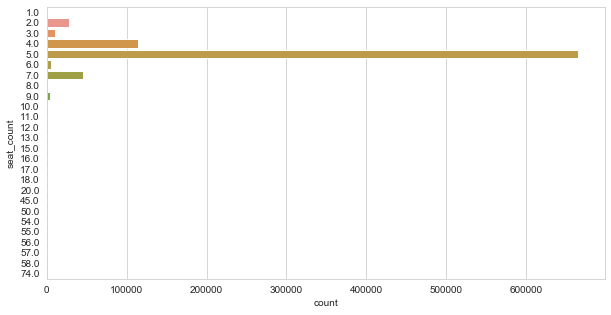

In [160]:
for i in ['door_count', 'seat_count']:
    plt.figure(figsize=(10,5))
    sns.countplot(y=df[i])
    plt.show()

Droping cars with atypical door count and seat count, since data scraped should include regular cars only.

In [161]:
df = df[df['door_count'].between(2,5)]

In [162]:
df = df[df['seat_count'].between(2,7)]

### Imputing missing values with means and mode for groups

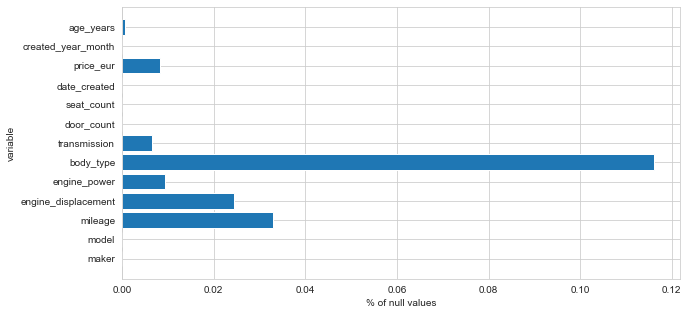

In [163]:
plt.figure(figsize=(10,5))
plt.barh(df.columns, width = df.isnull().sum()/len(df))
plt.xlabel('% of null values')
plt.ylabel('variable')
plt.show()

Inputing millage with mean in accordance to age of a car

In [164]:
df['mileage'] = df['mileage'].fillna(df.groupby(['age_years'])['mileage'].transform('mean'))

Imputing engine_power, engine_displacement, seat_count and transmission with a mode for model and manufacture_year

In [165]:
vars = ['seat_count', 'transmission', 'engine_power', 'engine_displacement']
for i in vars:
    df[i] = df.groupby(['model'])[i].transform(lambda x: x.fillna(x.mode()))

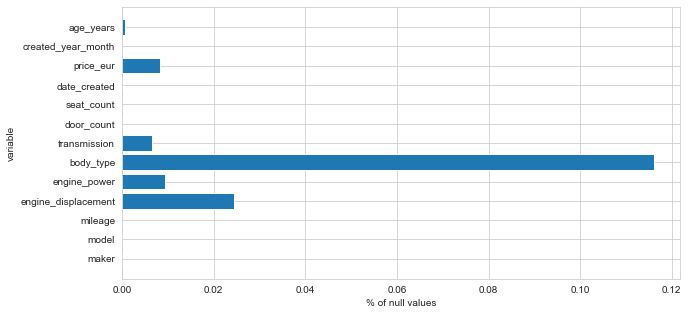

In [166]:
plt.figure(figsize=(10,5))
plt.barh(df.columns, width = df.isnull().sum()/len(df))
plt.xlabel('% of null values')
plt.ylabel('variable')
plt.show()

As we have reached serious imporovement in data quality, let's remove the records with missing values.

In [167]:
df.dropna(inplace=True)

In [168]:
len(df), len(df)/raw_len

(704326, 0.39575501966059484)

<b>The cleaned dataset consists now of 704 326 cars, that is 40% of the initial file for the specified period.

### Checking outh distributions of the dimension variables

In [169]:
df['body_type'].value_counts(normalize=True)

other          0.983840
compact        0.007066
van            0.004972
convertible    0.001400
coupe          0.001374
transporter    0.001347
Name: body_type, dtype: float64

The category 'other' is prevailing over the body_type variable. The value of this variable is doubtful since 'other' includes most brands and models (SUV cars, truckts, as well as small compact cars). 

In [170]:
df[df['body_type']=='other'].head()

,maker,model,mileage,engine_displacement,engine_power,body_type,transmission,door_count,seat_count,date_created,price_eur,created_year_month,age_years
1260447,audi,q3,63933.0,1968.0,174.332872,other,auto,4.0,5.0,2016-01-16 01:34:02.783133+00,27990.0,2016_01,4.0
1256544,toyota,yaris,14.0,1364.0,88.507458,other,man,5.0,5.0,2016-01-15 22:12:36.407341+00,13900.0,2016_01,1.0
1264644,mazda,cx-7,113916.0,2261.0,256.135219,other,man,4.0,5.0,2016-01-16 06:08:28.84931+00,9300.0,2016_01,8.0
1263957,hyundai,santa-fe,156559.0,2656.0,186.402070,other,man,5.0,5.0,2016-01-16 05:36:51.790394+00,5250.0,2016_01,9.0
1265522,nissan,qashqai,122105.0,1461.0,108.622789,other,man,5.0,5.0,2016-01-16 07:49:49.913239+00,12350.0,2016_01,5.0


In [171]:
df.drop(columns='body_type', inplace=True)

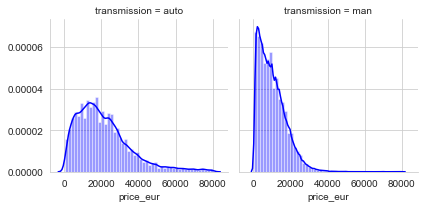

In [172]:
ax = sns.FacetGrid(data=df,col='transmission')
ax.map(sns.distplot, 'price_eur', color='blue')
plt.show()

It also seems that price distributions vs. transmission differ, so this variable will be included in modelling.

*************************

### Sampling the data frame to speed up modeling

<b> Before we go further with modeling I will make a sample of the dataset. This will speed up the learning process.

In [173]:
# original data size in volume and as % of raw dataframe.
len(df), len(df)/raw_len

(704326, 0.39575501966059484)

In [174]:
df = df.sample(n=50000, random_state=random_seed).reset_index(drop=True)

In [175]:
len(df)

50000

In [176]:
df.head()

,maker,model,mileage,engine_displacement,engine_power,transmission,door_count,seat_count,date_created,price_eur,created_year_month,age_years
0,seat,altea,89000.0,1598.0,103.258701,man,5.0,5.0,2016-02-17 12:51:29.570457+00,11900.0,2016_02,5.0
1,ford,focus,100000.0,1560.0,107.281767,man,5.0,5.0,2016-02-21 18:48:04.139541+00,7500.0,2016_02,5.0
2,suzuki,swift,163000.0,1248.0,68.392127,man,3.0,4.0,2016-03-09 16:59:32.12635+00,2900.0,2016_03,9.0
3,mercedes-benz,vito,112561.0,2148.0,93.871546,man,4.0,3.0,2016-03-07 11:19:14.522007+00,12900.0,2016_03,6.0
4,porsche,panamera,41059.0,2967.0,296.365882,auto,4.0,4.0,2016-02-12 10:48:18.152636+00,58004.0,2016_02,2.0


In [177]:
numeric_cols = ['price_eur' , 'age_years', 'mileage', 'engine_displacement', 'engine_power'] 

The graph below shows that there is a big variance over car metrics. We can see the presence of outlier values.

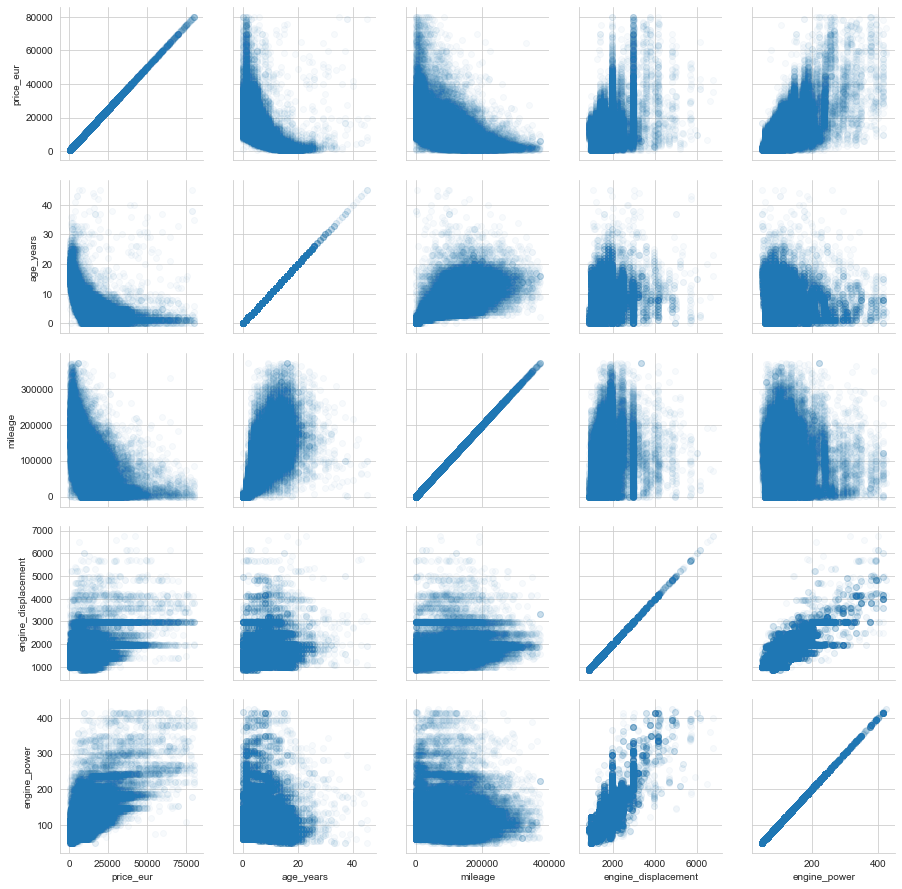

In [178]:
graph = sns.PairGrid(df[numeric_cols])
graph.map(plt.scatter, alpha=0.03)
plt.show()

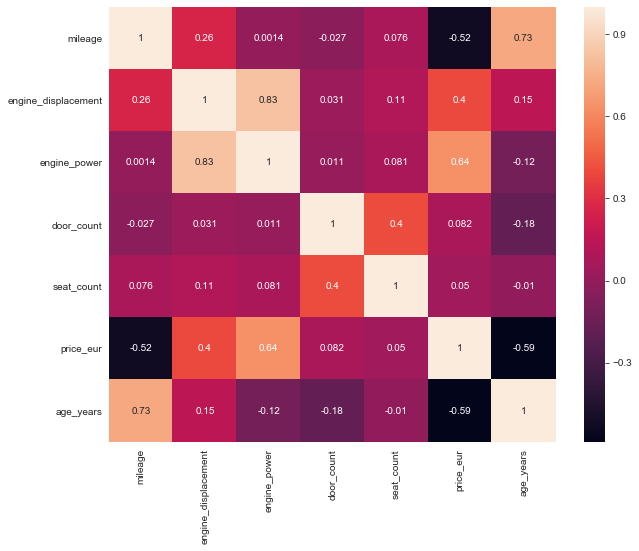

In [179]:
# Using Pearson Correlation Matrix
fig = plt.figure(figsize=(10,8))
cor = df.corr()
ax = sns.heatmap(cor, annot=True)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

Apart from:
- engine_power vs. engine_displacement (cor=0.82,  
- mileage vs. age_years (cor=0.73)
- price_eur vs. engine_power (cor=0.64)

there is no other significant correlation between metrics. 

*************************

## Attempt to cluster cars before modelling

<b> Since we dropped much of categorical data in order predict car prices I will attempt to cluster cars into some homogenic groups. If the clustering will go fine, the clusters will be considered in furher price predictions, if not I will skip this step and go on with modeling section with no additional information about clusters.

In [180]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score

Please note that due to manufacturer downsizing the same engine_displacement can result in completely different engine_power in accordance to age and make of a car.

In [181]:
# an expample how engine_power varies across the same engine_displacement
df['engine_power'][df['engine_displacement'].between(1490,1495)].describe()

count     62.000000
mean      95.126051
std       11.996607
min       67.051104
25%       87.501691
50%       95.883079
75%      107.281767
max      112.645855
Name: engine_power, dtype: float64

In [182]:
data_for_clustering = df[['engine_power', 'seat_count']]
data_for_clustering.head()

,engine_power,seat_count
0,103.258701,5.0
1,107.281767,5.0
2,68.392127,4.0
3,93.871546,3.0
4,296.365882,4.0


In [183]:
#MiniBatchClustering
data_clustered = StandardScaler().fit_transform(data_for_clustering)

clusters = range(2, 15)
silhouette = []
inertia  = []
for k in clusters:
    
    model = MiniBatchKMeans(n_clusters=k, batch_size=1000, random_state=random_seed)
    
    model.fit(data_clustered)
    
    silhouette.append(silhouette_score(data_clustered, model.predict(data_clustered)))
    inertia.append(model.inertia_)

Plotting Silhouette and Inertia scores to set up optimal number of clusters:

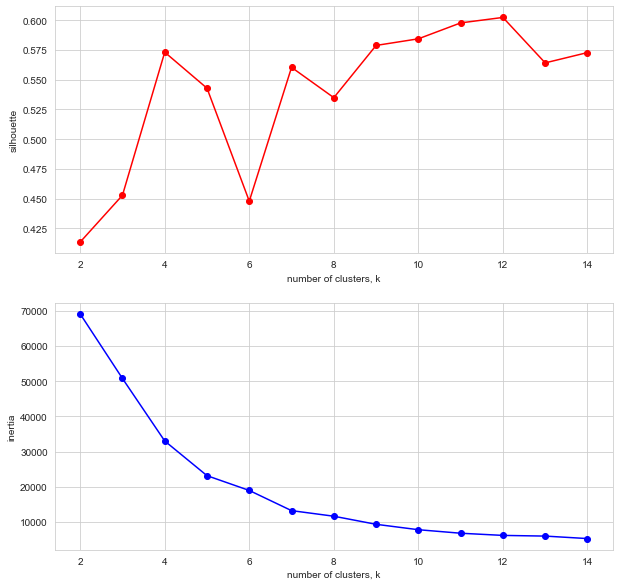

In [184]:
# Plot clusters vs silhouette
plt.figure(figsize=(10,10))

plt.subplot(2, 1, 1)
plt.plot(clusters, silhouette, 'r-o', )
plt.xlabel('number of clusters, k')
plt.ylabel('silhouette')

plt.subplot(2, 1, 2)
# Plot clusters vs silhouette
plt.plot(clusters, inertia, 'b-o')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')

plt.show()

The optimal values out of the specified cluster range is 6.

In [185]:
cluster_model = MiniBatchKMeans(n_clusters=12)
cluster_model.fit(data_clustered)

MiniBatchKMeans(batch_size=100, compute_labels=True, init='k-means++',
                init_size=None, max_iter=100, max_no_improvement=10,
                n_clusters=12, n_init=3, random_state=None,
                reassignment_ratio=0.01, tol=0.0, verbose=0)

In [186]:
df['cluster']=cluster_model.predict(data_clustered)

In [187]:
df.head()

,maker,model,mileage,engine_displacement,engine_power,transmission,door_count,seat_count,date_created,price_eur,created_year_month,age_years,cluster
0,seat,altea,89000.0,1598.0,103.258701,man,5.0,5.0,2016-02-17 12:51:29.570457+00,11900.0,2016_02,5.0,11
1,ford,focus,100000.0,1560.0,107.281767,man,5.0,5.0,2016-02-21 18:48:04.139541+00,7500.0,2016_02,5.0,11
2,suzuki,swift,163000.0,1248.0,68.392127,man,3.0,4.0,2016-03-09 16:59:32.12635+00,2900.0,2016_03,9.0,6
3,mercedes-benz,vito,112561.0,2148.0,93.871546,man,4.0,3.0,2016-03-07 11:19:14.522007+00,12900.0,2016_03,6.0,8
4,porsche,panamera,41059.0,2967.0,296.365882,auto,4.0,4.0,2016-02-12 10:48:18.152636+00,58004.0,2016_02,2.0,7


In [188]:
df['cluster'].value_counts()

11    11607
9      9427
5      8267
1      6514
6      3594
4      2834
0      2261
10     1670
3      1248
2      1175
7       839
8       564
Name: cluster, dtype: int64

In [189]:
groups = df.groupby(by='cluster')['price_eur', 'engine_power', 'seat_count', 'door_count', 'age_years'].mean()

Check out how the clusters are formed:

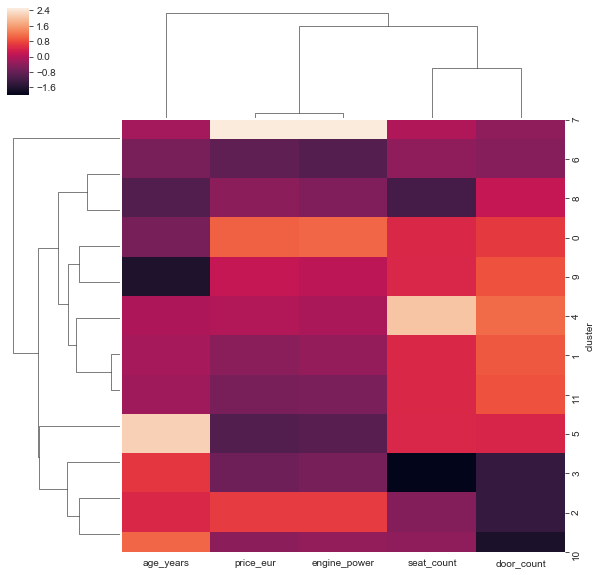

In [190]:
sns.clustermap(groups, z_score=1)
plt.show()

In [191]:
print(groups)

            price_eur  engine_power  seat_count  door_count  age_years
cluster                                                               
0        25002.095290    226.042588    5.014595    4.263158   6.025210
1        11600.723000    121.662448    5.009518    4.460854   6.458858
2        21897.475983    196.622371    3.840851    2.820426   6.988085
3         8928.338229     97.566879    2.000000    2.816506   7.133814
4        15479.169936    139.020552    6.962950    4.592802   6.521877
5         5891.961141     72.330355    5.001573    4.099552   8.525221
6         7377.664343     70.551045    4.000000    3.458820   6.045910
7        38924.840453    335.925234    4.394517    3.533969   6.450536
8        11625.250301    105.446184    3.000000    3.920213   5.666667
9        17332.094635    153.389626    5.004455    4.428238   5.144479
10       11738.831371    120.512114    4.000000    2.601198   7.518563
11        9901.562360    100.403469    5.006548    4.430430   6.399845


As we can see below one car model falls into several clusters, whis is not what we would like to accept, since prices are rather differentiated in accordance to models. Have a look ford mondeo, which falls into two clusters 5 and 0:

In [192]:
df[(df['maker']=='ford') & (df['model']=='mondeo')]

,maker,model,mileage,engine_displacement,engine_power,transmission,door_count,seat_count,date_created,price_eur,created_year_month,age_years,cluster
594,ford,mondeo,225000.0,1796.0,113.986878,man,5.0,5.0,2016-02-18 21:14:55.401806+00,750.00,2016_02,18.0,1
994,ford,mondeo,27480.0,1997.0,177.014916,auto,4.0,5.0,2016-03-09 12:07:20.833907+00,28489.00,2016_03,1.0,9
1059,ford,mondeo,223000.0,1597.0,93.871546,man,4.0,5.0,2016-03-02 10:39:38.320086+00,690.93,2016_03,16.0,11
1065,ford,mondeo,53806.0,1997.0,160.922651,man,5.0,5.0,2016-02-12 10:59:05.024831+00,17930.00,2016_02,3.0,9
1183,ford,mondeo,158000.0,2198.0,152.876518,man,5.0,5.0,2016-02-23 14:48:50.473107+00,4999.00,2016_02,11.0,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...
49779,ford,mondeo,171770.0,1998.0,128.738121,man,5.0,5.0,2016-03-14 09:05:00.253676+00,1406.37,2016_03,13.0,1
49799,ford,mondeo,247000.0,1798.0,123.374032,man,5.0,5.0,2016-03-06 21:40:54.235665+00,1500.00,2016_03,14.0,1
49811,ford,mondeo,43000.0,1997.0,138.125275,man,4.0,5.0,2016-03-10 03:38:30.625903+00,16490.00,2016_03,3.0,9
49822,ford,mondeo,119000.0,1999.0,143.489364,man,5.0,5.0,2016-02-14 18:52:50.706303+00,6999.00,2016_02,9.0,9


Despite that I will inlude clusters in the modelling proces, since had previously dropped a few categorical variables due to data quality.

In [193]:
df.to_csv('.\Cars_sample_cleaned_50k.csv')

***************

## 3. Modeling car prices

### Defining target variable and split dataset into training and testing set

In [2]:
from sklearn.model_selection import train_test_split
from sklearn import model_selection
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import GridSearchCV

from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet

from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from keras.callbacks import EarlyStopping

from sklearn import  metrics

Using TensorFlow backend.


In [3]:
df = pd.read_csv('./Cars_sample_cleaned_50k.csv', sep=',', low_memory=False, index_col=[0])

In [4]:
df.shape

(50000, 13)

In [5]:
df.columns

Index(['maker', 'model', 'mileage', 'engine_displacement', 'engine_power',
       'transmission', 'door_count', 'seat_count', 'date_created', 'price_eur',
       'created_year_month', 'age_years', 'cluster'],
      dtype='object')

In [6]:
df.dtypes

maker                   object
model                   object
mileage                float64
engine_displacement    float64
engine_power           float64
transmission            object
door_count             float64
seat_count             float64
date_created            object
price_eur              float64
created_year_month      object
age_years              float64
cluster                  int64
dtype: object

In [7]:
df['transmission'].value_counts()

man     39389
auto    10611
Name: transmission, dtype: int64

In [8]:
df['transmission'] = df['transmission'].apply(lambda x: 0 if (x=='man') else 1) 

In [9]:
cat_variables = ['door_count', 'seat_count', 'cluster']

for i in cat_variables:
    df[i] = df[i].astype('category')

In a series of experiments it turned out that cluster did not increase prediction accuracy, so I decide to drop it.

In [10]:
y = df['price_eur']
X = df.drop(['maker', 'model', 'price_eur', 'date_created', 'created_year_month', 'cluster'], axis=1)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed)

In [12]:
X.head()

,mileage,engine_displacement,engine_power,transmission,door_count,seat_count,age_years
0,89000.0,1598.0,103.258701,0,5.0,5.0,5.0
1,100000.0,1560.0,107.281767,0,5.0,5.0,5.0
2,163000.0,1248.0,68.392127,0,3.0,4.0,9.0
3,112561.0,2148.0,93.871546,0,4.0,3.0,6.0
4,41059.0,2967.0,296.365882,1,4.0,4.0,2.0


### Setting up kfold cross-validation criteria

In [13]:
kfold = model_selection.KFold(n_splits=5, random_state=random_seed)

### Specifing pipeline

Creating the preprocessing pipeline for both numeric and categorical data, and separately for each type to use it across models.

In [14]:
numeric_features = ['mileage', 'engine_displacement','engine_power', 'age_years']
# since tranmission is coded 0/1 now, there is no need to scale it.
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

categorical_features = ['door_count', 'seat_count' ] 
#'cluster' - I decided to drop it from computations since it did not improve the score.
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

full_preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

num_preprocessor_only = ColumnTransformer(
    transformers=[('num', numeric_transformer, numeric_features)])

cat_preprocessor_only = ColumnTransformer(
    transformers=[('cat', categorical_transformer, categorical_features)])


##  Polynomial linear regression

In [15]:
param_grid = {'polynomialfeatures__degree': [1, 2, 3, 4]}

lm_1 = GridSearchCV(
    make_pipeline(#cat_preprocessor_only, # it seems that one hot cat_preprocessing on 'door_count' and 'seat_count' worsens the prediction
                  PolynomialFeatures(degree=2), 
                  linear_model.LinearRegression()),
    param_grid=param_grid,
    cv=kfold,
    refit=True, 
    n_jobs=-1)

lm_1.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=False),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('polynomialfeatures',
                                        PolynomialFeatures(degree=2,
                                                           include_bias=True,
                                                           interaction_only=False,
                                                           order='C')),
                                       ('linearregression',
                                        LinearRegression(copy_X=True,
                                                         fit_intercept=True,
                                                         n_jobs=None,
                                                         normalize=False))],
                                verbose=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'polynomialfeatures__degr

In [16]:
print(lm_1.best_params_, 
      '\nR2:', metrics.r2_score(y_test, lm_1.predict(X_test)), 
      '\nMAE:', metrics.mean_absolute_error(y_test, lm_1.predict(X_test)))

{'polynomialfeatures__degree': 3} 
R2: 0.861087876530106 
MAE: 2473.562660566353


## Polynomial linear regression - ridge regularization 

In [17]:
param_grid={'polynomialfeatures__degree': [1, 2, 3, 4 ],
            'ridge__alpha': [0.01, 0.1, 1, 10, 100]}

lm_2_rr = GridSearchCV(
    make_pipeline(#cat_preprocessor_only, # it seems that one hot cat_preprocessing on 'door_count' and 'seat_count' worsens the prediction
                  PolynomialFeatures(degree=2), 
                  linear_model.Ridge(random_state=random_seed)),
    param_grid=param_grid,  
    cv=kfold,
    refit=True, 
    n_jobs=-1)

lm_2_rr.fit(X_train, y_train)

C:\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.09101e-36): result may not be accurate.
  overwrite_a=True).T


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=False),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('polynomialfeatures',
                                        PolynomialFeatures(degree=2,
                                                           include_bias=True,
                                                           interaction_only=False,
                                                           order='C')),
                                       ('ridge',
                                        Ridge(alpha=1.0, copy_X=True,
                                              fit_intercept=True, max_iter=None,
                                              normalize=False, random_state=42,
                                              solver='auto', tol=0.001))],
                                verbose=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'polynomialfeatures__deg

In [18]:
print(lm_2_rr.best_params_, 
      '\nR2:', metrics.r2_score(y_test, lm_2_rr.predict(X_test)), 
      '\nMAE:', metrics.mean_absolute_error(y_test, lm_2_rr.predict(X_test)))

{'polynomialfeatures__degree': 3, 'ridge__alpha': 1} 
R2: 0.8681235749557445 
MAE: 2393.493446753084


## Polynomial linear regression - lasso regularization

In [19]:
param_grid={'polynomialfeatures__degree': [1, 2, 3, 4],
            'lasso__alpha': [0.01, 0.1, 1, 10, 100]}

lm_3_lr = GridSearchCV(
    make_pipeline(
        #cat_preprocessor_only, # it seems that one hot cat_preprocessing on 'door_count' and 'seat_count' worsens the prediction 
        PolynomialFeatures(degree=2), linear_model.Lasso(random_state=random_seed)),
    param_grid=param_grid,
    cv=kfold,
    refit=True, 
    n_jobs=-1)

lm_3_lr.fit(X_train, y_train)

C:\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 301549854453.0621, tolerance: 432220144.7803217
  positive)


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=False),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('polynomialfeatures',
                                        PolynomialFeatures(degree=2,
                                                           include_bias=True,
                                                           interaction_only=False,
                                                           order='C')),
                                       ('lasso',
                                        Lasso(alpha=1.0, copy_X=True,
                                              fit_intercept=True, max_iter=1000,
                                              normalize=False, positive=False,
                                              precompute=False, random_state=42,
                                              selection='cyclic', tol=0.0001,
                                              warm_start

In [20]:
print(lm_3_lr.best_params_, 
      '\nR2:', metrics.r2_score(y_test, lm_3_lr.predict(X_test)), 
      '\nMAE:', metrics.mean_absolute_error(y_test, lm_3_lr.predict(X_test)))

{'lasso__alpha': 10, 'polynomialfeatures__degree': 3} 
R2: 0.8663146860291455 
MAE: 2398.919277809441


## Polymomial linear regression - elasticnet regularization

In [21]:
param_grid={'polynomialfeatures__degree': [1, 2, 3,4],
            'elasticnet__alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]}

lm_4_en = GridSearchCV(
    make_pipeline(
        #cat_preprocessor_only, # it seems that one hot cat_preprocessing on 'door_count' and 'seat_count' worsens the prediction 
        PolynomialFeatures(degree=2), linear_model.ElasticNet(alpha=1, random_state=random_seed)),
    param_grid=param_grid,
    cv=kfold,
    refit=True, 
    n_jobs=-1)

lm_4_en.fit(X_train, y_train)

C:\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 301060699885.8725, tolerance: 432220144.7803217
  positive)


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=False),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('polynomialfeatures',
                                        PolynomialFeatures(degree=2,
                                                           include_bias=True,
                                                           interaction_only=False,
                                                           order='C')),
                                       ('elasticnet',
                                        ElasticNet(alpha=1, copy_X=True,
                                                   fit_intercept=True,
                                                   l1_ratio=0.5, max_iter=1000,
                                                   normalize=False,
                                                   positive=False,
                                                   precompute=False,
            

In [22]:
print(lm_4_en.best_params_, 
      '\nR2:', metrics.r2_score(y_test, lm_4_en.predict(X_test)), 
      '\nMAE:', metrics.mean_absolute_error(y_test, lm_4_en.predict(X_test)))

{'elasticnet__alpha': 0.1, 'polynomialfeatures__degree': 3} 
R2: 0.866309854259581 
MAE: 2398.9930952219765


## Support Vector Regression

In [23]:
# This part was skipped due to the fact that algorithm did not manage to train the model within 12 hours.

In [24]:
# pipe = Pipeline([('preprocessing', make_pipeline(full_preprocessor)), ('SVR', SVR(kernel='rbf'))])

# param_grid = {'preprocessing': [make_pipeline(full_preprocessor), make_pipeline(cat_preprocessor_only), None],
#               'SVR__gamma': [0.001, 0.01, 0.1, 1, 10, 100],
#               'SVR__C': [1, 10, 100, 1000, 10000, 20000]}

# svr_5 = GridSearchCV(pipe, 
#                      param_grid, 
#                      cv=kfold, 
#                      return_train_score=True,
#                      n_jobs=-1)

# svr_5.fit(X_train, y_train)

In [25]:
# print(svr_5.best_params_, 
#       '\nR2:', metrics.r2_score(y_test, svr_5.predict(X_test)), 
#       '\nMAE:', metrics.mean_absolute_error(y_test, svr_5.predict(X_test)))

## Random forest regression

In [26]:
param_grid = {'n_estimators': [20, 50, 100, 200, 500],
              'max_depth':  [20, 50, 100, 200],  
              'max_features': ['log2','sqrt','auto'],
              'max_leaf_nodes':  [100, 200, 300, 500]}

rfr = RandomForestRegressor(n_jobs=-1, max_features='sqrt', n_estimators=50, 
                            oob_score = True, random_state=random_seed)
                 
rfr_6 = GridSearchCV(rfr,
                     param_grid=param_grid,
                     cv=kfold, 
                     n_jobs=-1)

rfr_6.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=False),
             error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='sqrt',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=50, n_jobs=-1,
                                             oob_score=True, random_state=42,
                                             verbose=0,

In [27]:
print(rfr_6.best_params_, 
      '\nR2:', metrics.r2_score(y_test, rfr_6.predict(X_test)), 
      '\nMAE:', metrics.mean_absolute_error(y_test, rfr_6.predict(X_test)))

{'max_depth': 50, 'max_features': 'log2', 'max_leaf_nodes': 500, 'n_estimators': 500} 
R2: 0.9002972849108568 
MAE: 2119.8365636440644


Printing out feature importances for RFR model:

In [28]:
feat_importances = pd.Series(data=rfr_6.best_estimator_.feature_importances_, index=X_train.columns).sort_values(ascending=True)

In [29]:
feat_importances.index

Index(['door_count', 'seat_count', 'transmission', 'engine_displacement',
       'mileage', 'engine_power', 'age_years'],
      dtype='object')

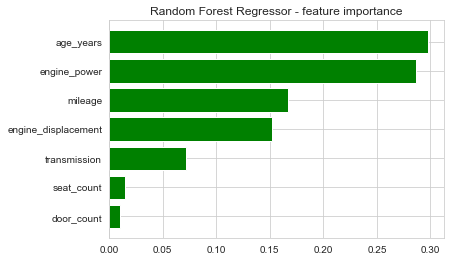

In [30]:
plt.barh(feat_importances.index, feat_importances.values, color='green')
plt.title('Random Forest Regressor - feature importance')
plt.show()

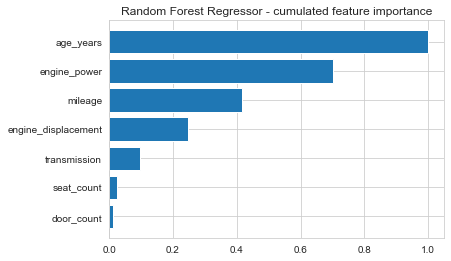

In [31]:
plt.barh(feat_importances.index, feat_importances.values.cumsum())
plt.title('Random Forest Regressor - cumulated feature importance')
plt.show()

As it was shown in the correlation matrix the most important features to predict car prices is age power, engine_displacement and mileage. The remaining predictors are of minor imporance.

## Gradient Boosting Regressor

In [32]:
pipe = Pipeline([('preprocessing', make_pipeline(full_preprocessor)), 
                 ('GBR', GradientBoostingRegressor(loss='ls', n_estimators=50, random_state=random_seed))])

param_grid = {'preprocessing': [make_pipeline(full_preprocessor), make_pipeline(cat_preprocessor_only), None],
              'GBR__n_estimators': [50, 100, 200, 500, 700]
             }

gbr_7 = GridSearchCV(pipe,
                     param_grid=param_grid,
                     cv=kfold, 
                     n_jobs=-1)

gbr_7.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=False),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('preprocessing',
                                        Pipeline(memory=None,
                                                 steps=[('columntransformer',
                                                         ColumnTransformer(n_jobs=None,
                                                                           remainder='drop',
                                                                           sparse_threshold=0.3,
                                                                           transformer_weights=None,
                                                                           transformers=[('num',
                                                                                          Pipeline(memory=None,
                                                                         

In [33]:
print(gbr_7.best_params_, 
      '\nR2:', metrics.r2_score(y_test, gbr_7.predict(X_test)), 
      '\nMAE:', metrics.mean_absolute_error(y_test, gbr_7.predict(X_test)))

{'GBR__n_estimators': 700, 'preprocessing': None} 
R2: 0.9097247445551276 
MAE: 1988.8117028795245


## Baseline Neural Network KerasRegressor

In [34]:
full_preprocessor.fit_transform(X_test).shape

(10000, 14)

In [ ]:
def build_regressor():
    model = Sequential()
    model.add(Dense(14, input_shape=(14,), kernel_initializer='normal', activation='relu'))
    model.add(Dense(42, kernel_initializer='normal', activation='relu'))
    model.add(Dense(28, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    model.compile(loss="mse", optimizer="adam", metrics=['mae'])
    print(model.summary())
    return model

early_stopping = EarlyStopping(monitor='loss', patience=10)

Keras_Regressor_model = KerasRegressor(build_fn=build_regressor, 
                                       epochs=300, 
                                       batch_size=20, 
                                       verbose=2)

pipe = Pipeline([('preprocessing', make_pipeline(full_preprocessor)),
                     ('KR', Keras_Regressor_model)])           


param_grid = {'preprocessing': [make_pipeline(full_preprocessor), make_pipeline(cat_preprocessor_only)],
              'KR__batch_size': [20, 32, 50]
             }

kerasNNR_8 = GridSearchCV(pipe,
                     param_grid=param_grid,
                     cv=kfold)

kerasNNR_8.fit(X_train, y_train)

Model: "sequential_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_141 (Dense)            (None, 14)                210       
_________________________________________________________________
dense_142 (Dense)            (None, 42)                630       
_________________________________________________________________
dense_143 (Dense)            (None, 28)                1204      
_________________________________________________________________
dense_144 (Dense)            (None, 1)                 29        
Total params: 2,073
Trainable params: 2,073
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/300
 - 2s - loss: 72310672.9453 - mae: 5120.1621
Epoch 2/300
 - 2s - loss: 24307438.4983 - mae: 3118.4724
Epoch 3/300
 - 3s - loss: 22622788.8287 - mae: 2907.3015
Epoch 4/300
 - 2s - loss: 21613588.7733 - mae: 2824.4087
Epoch 5/300
 - 2

In [ ]:
print(#kerasNNR.best_params_,
      '\nR2:', metrics.r2_score(y_test, kerasNNR.predict(X_test)), 
      '\nMAE:', metrics.mean_absolute_error(y_test, kerasNNR.predict(X_test)))

## 5. Model Comparison Summary

In [ ]:
models = []
models.append(('Poly Linear', lm_1.best_estimator_))
models.append(('Poly Ridge', lm_2_rr.best_estimator_))
models.append(('Poly Lasso', lm_3_lr.best_estimator_))
models.append(('Poly ElasticNet', lm_4_en.best_estimator_))
#models.append(('Support Vector Regressor', svr_5.best_estimator_))
models.append(('Random Forrest', rfr_6.best_estimator_))
models.append(('Gradient Boosting', gbr_7.best_estimator_))
models.append(('Keras NN Regressor', kerasNNR_8))

r2 = []
mean_absolute_error = []
for name, model in models:
    print(name)
    print("R^2: {}".format(metrics.r2_score(y_test, model.predict(X_test)) ))
    print("Mean absolute error: {}".format( metrics.mean_absolute_error(y_test, model.predict(X_test)) ))
    r2.append(metrics.r2_score(y_test, model.predict(X_test)))
    mean_absolute_error.append(metrics.mean_absolute_error(y_test, model.predict(X_test)))
    print("------------------------------------------")
    

In [ ]:
d = {'R2': r2, 
     'MAE': mean_absolute_error}
df_models = pd.DataFrame(data=d)
df_models.insert(loc=0, column='Method', value=['Polynomial Linear Regression',
                                                'Polynomial LR - Ridge',
                                                'Polynomial LR - Lasso', 
                                                'Polynomial LR - ElasticNet',
                                                #'Support Vector Regressor',
                                                'Random Forrest Regressor',
                                                'Gradient Boosting Regressor',
                                                'Keras NN Regressor'])
df_models.set_index('Method', inplace=True)

df_models.to_csv('./model_results.csv')

In [ ]:
plt.style.use('ggplot')
plt.figure(figsize=(12,5))
plt.subplot(121)

values = df_models['R2']  
idx = df_models.index

clrs = ['grey' if (x < max(values)) else 'red' for x in values ]
sns.barplot(x=idx, y=values, palette=clrs)
plt.ylabel('R2')
plt.xlabel('Method')
plt.xticks(rotation=90)


plt.subplot(122)

values2 = df_models['MAE']  
idx2 = df_models.index

clrs = ['grey' if (x > min(values2)) else 'red' for x in values2 ]
sns.barplot(x=idx, y=values2, palette=clrs)
plt.xticks(rotation=90)
plt.ylabel('MAE')
plt.xlabel('Method')

plt.show()

# Project summary

<b> On the 50 000 car dataset that was sampled from cleaned dataset I managed to reach: <font color=blue> 91% R2 score and 1889 of MAE </font>.
This means that our predicions vary from real prices about nearly EUR 1900 on average, which is some 16%.</b>


Gradient Boosting Regressor proved to be the best algorithm out of the methods checked. The second one was Random Forest Regressor. Keras Neural Network did not work that well on the dataset, but this algorithm was run just without tunning to check as it was not tuned. Since SVR was very slow, I decided to drop it from the algorithm competition (12 hours was still not enough to train the model on the sample dataset). 

It is still not perfect, but it is more than I expected. After cleaning the dataset, just before starting to create first models, I was very anxious how my modelling will perform. Real data is far more challenging than ordinary, ready-to-used datasets that I got used to during my bootcamp clasesss. In the modelling process different approaches were checked, and some variables ned to be removed form the process. 
        
Moreover the project proved that if a categorical variable is inbalanced (such as it was a case in 'cluster', 'seat_number', or 'door_number') and as it is not directly correlated with target variable, it increases the model clomplexity, not bringing better prediction accuracy in return. As in ML no holds are barred, sometimes no variable preprocessing can bring out better results (as I decided to remove One Hot Encoding for the cariables 'seat_number' or 'door_number').
   
There is still a place to improve by tunning up models, especially neural networks. This will be performed later on as a supplement to this project (as I need to get my Laptop rest after a series of busy days).

In [ ]:
# mae as % of mean price_eur 
metrics.mean_absolute_error(y_test, gbr_7.predict(X_test))/y_test.mean()

### Comparing predicted prices to real car ad prices

In [ ]:
price_predictions = pd.DataFrame(gbr_7.predict(X).round(), columns=['predicted_price_eur'])

In [ ]:
df = df[['price_eur', 'maker', 'model', 'age_years',
         'mileage', 'engine_displacement', 'engine_power', 'transmission', 'cluster']]

In [ ]:
frames = [price_predictions, df]
df_with_predictions = pd.concat(frames, axis=1)
df_with_predictions.head(20)

In [ ]:
sns.set()
sns.lmplot(x='price_eur', y='predicted_price_eur', data=df_with_predictions, line_kws={'color': 'green'})
plt.show()